# Compute couplings for all methods (ABpxp)

Use the hpyerparameters we identified in the gridsearch to produce a set of couplings, linking cells across time points using the different methods

## Preliminaries

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

Configure JAX to use x64

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

Import other packages. 

In [3]:
# custom utilities
import utils

# single cell packages
import scanpy as sc
import scvelo as scv
import moscot as mc
import anndata
import utils
import networkx as nx
import time

# rest
import pickle
import sys
import warnings
import numpy as np
import scipy.sparse as sp
import ott
import pandas as pd
from typing import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Print the moscot and OTT versions. 

In [4]:
mc.__version__

'0.3.4.dev158+gee31deb'

In [5]:
ott.__version__

'0.4.6.dev8+gcbff1c7'

Check GPU access. 

In [6]:
from jax.lib import xla_bridge

xla_bridge.get_backend().platform

'gpu'

### Dependencies

This notebook depends on [ML_2024-03-11_prepare_data.ipynb](ML_2024-03-11_prepare_data.ipynb). 

### Define utility functions

### Set up paths

Define the paths for data and figures

In [7]:
sys.path.insert(
    0, "../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "packer_c_elegans"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [8]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)

### Set global parameters

In [9]:
LINEAGE_INFO = "abpxp"
write_data = True
TIME_KEY = "assigned_batch_time"

### Import the data

Import the AnnData object - this contains all cells for which we have at least partial lineage information. 

In [10]:
adata = sc.read(DATA_DIR / "ML_2023-04-11_c_elegans_prep.h5ad")
adata

AnnData object with n_obs × n_vars = 46151 × 20222
    obs: 'idx', 'barcode', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF'
    uns: 'clusters_colors', 'coarse_clusters_colors'

In addition, import the grid search results to inform our choice of hyperparematers. The results of our gridsearch are included in this repositroy in `data/packer_c_elegans`. 

In [11]:
grid_df = pd.read_csv(
    DATA_DIR / "ML_2024-03-11_celegans_precise_and_abpxp.csv", index_col=0
)

Import UMAP coordinates. 

In [12]:
umap_df = pd.read_csv(DATA_DIR / 'abpxp_umap.csv', index_col=0)
umap_df.head()

,umap_1,umap_2
cell,,
AAAGCAAGTACTCGCG-r17,11.935756,14.227101
AACGTTGCAAGTCATC-b01,13.703837,12.810205
AACTCAGTCTGTCTAT-b01,12.992493,12.792275
AATCCAGAGGCATGGT-b01,12.977440,13.303903
AATCCAGAGTGTCTCA-b01,12.961439,12.664324


### Preprocessing and filtering

Download the C. elegans lineage tree [(Packer et al., Science 2019)](https://www.science.org/doi/10.1126/science.aax1971) from [figshare](https://doi.org/10.6084/m9.figshare.c.6533377.v1). Subset to the ABpxp lineage, preprocess the data, compute PCA, and write the lineage tree to `.uns`. 

In [13]:
# download from FigShare
# _, full_reference_tree = mc.datasets.c_elegans(DATA_DIR / "c_elegans")

# load it from local
full_reference_tree = nx.read_gml(DATA_DIR / "ML_2023-11-06_packer_lineage_tree.gml")

# preprocess the AnnData object
adata = utils.preprocess(adata, full_reference_tree, lineage_info=LINEAGE_INFO, seed=0)

Check what has been written

In [14]:
adata

AnnData object with n_obs × n_vars = 7356 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters', 'assigned_batch_time'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'coarse_clusters_colors', 'log1p', 'hvg', 'pca', 'trees'
    obsm: 'X_pca'
    varm: 'PCs'

Subset to time points that contain enough cells to confidently map them. 

In [15]:
tps = [170, 210, 270, 330, 390, 450, 510]
adata = adata[adata.obs[TIME_KEY].isin(tps)].copy()
adata

AnnData object with n_obs × n_vars = 7274 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters', 'assigned_batch_time'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'coarse_clusters_colors', 'log1p', 'hvg', 'pca', 'trees'
    obsm: 'X_pca'
    varm: 'PCs'

Save the `.uns` anntations

In [16]:
uns_original = adata.uns.copy()

## Run all methods

### Loop over time points, compute couplings

Retrieve all methods from the grid. 

In [17]:
methods = np.unique(grid_df['kind'])
methods

array(['GW', 'LineageOT', 'OT', 'moslin'], dtype=object)

For my own reference, let's look at some of these optimal results

In [18]:
hyper_df = utils.get_best_runs(
                df=grid_df, 
                lineage_info=LINEAGE_INFO, 
                group_key="kind", 
                group="OT", 
                converged=True
            )
hyper_df

Removing 2/30 not converged runs.


,_wandb,late_cost,early_cost,deviation_from_balanced,_step,_runtime,converged,_timestamp,mean_error,tp,kind,alpha,tau_a,epsilon,scale_cost,lineage_info,max_inner_iterations,name
545,{'runtime': 40},0.965902,0.975985,1.445135e-07,0,40.650914,True,1.699611e+09,0.970943,170-210,OT,0.0,1,0.50,mean,abpxp,30000.0,frosty-sweep-55
556,{'runtime': 307},0.698994,0.739514,7.861704e-07,0,308.488405,True,1.699611e+09,0.719254,210-270,OT,0.0,1,0.10,mean,abpxp,30000.0,dry-sweep-44
567,{'runtime': 1085},0.466375,0.513274,2.220446e-16,0,1085.702243,True,1.699611e+09,0.489825,270-330,OT,0.0,1,0.05,mean,abpxp,30000.0,stilted-sweep-33
566,{'runtime': 289},0.589242,0.658652,9.802394e-07,0,290.652961,True,1.699611e+09,0.623947,330-390,OT,0.0,1,0.05,mean,abpxp,30000.0,sunny-sweep-34
565,{'runtime': 68},0.268816,0.361229,0.000000e+00,0,69.228693,True,1.699610e+09,0.315022,390-450,OT,0.0,1,0.05,mean,abpxp,30000.0,visionary-sweep-35
552,{'runtime': 36},0.231975,0.241532,2.984063e-07,0,36.973779,True,1.699611e+09,0.236753,450-510,OT,0.0,1,0.10,mean,abpxp,30000.0,glamorous-sweep-48


Iterate over all time points and methods. 

In [19]:
adatas = {}

for t1, t2 in zip(tps[:-1], tps[1:]):

    # initialize dict for this time point pair
    adatas[t1, t2] = {}

    # iterate over all methods
    for method in methods:
        hyper_df = utils.get_best_runs(
            df=grid_df, 
            lineage_info=LINEAGE_INFO, 
            group_key="kind", 
            group=method, 
            converged=True
        )
        
        # extract hyperparameters from gridsearch results
        params = hyper_df.loc[hyper_df["tp"] == f"{t1}-{t2}"]
        alpha = params["alpha"].values[0]
        epsilon = params["epsilon"].values[0]
        scale_cost = params["scale_cost"].values[0]
        max_inner_iterations = params["max_inner_iterations"].values[0]
    
        # print these parameters and run moslin
        print(f"{t1=}, {t2=}, {epsilon=}, {alpha=} {scale_cost=} {max_inner_iterations=} {method=}")
    
        if method in ["moslin", "OT", "GW"]:
            prob, pred, conv, gt = utils.benchmark_moscot(
                adata=adata,
                early_time=t1,
                late_time=t2,
                alpha=alpha,
                epsilon=epsilon,
                scale_cost=scale_cost,
                max_inner_iterations=int(max_inner_iterations),
            )
        elif method == "LineageOT":
            pred, conv, gt = utils.benchmark_lot(
                adata=adata,
                early_time=t1,
                late_time=t2,
                epsilon=epsilon,
                scale_cost=scale_cost,
            ) 
        else:
            raise ValueError(f"Unrecognized method: {method}")
    
        # extract the internal AnnData object, and compute early and late cost
        bdata = prob.adata.copy()

        # remove old stuff
        for attr in ['pred', 'gt']:
            if attr in bdata.obsp.keys():
                del bdata.obsp[attr]
        if 'costs' in bdata.uns.keys():
            del bdata.uns["costs"]
            
        # compute early and late errors
        early_cost = gt.cost(pred, late=False)
        late_cost = gt.cost(pred, late=True)
        mean_error = (early_cost + late_cost) / 2
    
        # Write the predicted and ground truth coupling, as well as the costs, to AnnData
        src_ixs = np.where(bdata.obs[TIME_KEY] == t1)[0]
        tgt_ixs = np.where(bdata.obs[TIME_KEY] == t2)[0]
        d1 = sp.csc_matrix((len(src_ixs), len(src_ixs)))
        d2 = sp.csc_matrix((len(tgt_ixs), len(tgt_ixs)))
    
        bdata.obsp["pred"] = sp.bmat([[d1, pred], [None, d2]], format="csr")
        bdata.obsp["gt"] = sp.bmat([[d1, gt.coupling], [None, d2]], format="csr")
        bdata.uns["costs"] = {"early": early_cost, "late": late_cost}
    
        # check that the mean cost agrees with what we have in our table
        previous_mean_error = params["mean_error"].values[0]

        delta_error = mean_error - previous_mean_error
        if np.abs(delta_error) > 1e-4: 
            print(f"WARNING: new mean error - old mean error = {delta_error}")
        # assert(np.isclose(mean_error, previous_mean_error)), f"new mean error - old mean error = {mean_error - previous_mean_error}"
        
        print(f"{mean_error=}")
        adatas[t1, t2][method] = bdata

Removing 0/30 not converged runs.
t1=170, t2=210, epsilon=0.01, alpha=1.0 scale_cost='mean' max_inner_iterations=30000.0 method='GW'
INFO     Ordering Index(['AAAGCAAGTACTCGCG-r17', 'AACGTTGCAAGTCATC-b01', 'AACTCAGTCTGTCTAT-b01',                   
                'AATCCAGAGGCATGGT-b01', 'AATCCAGAGTGTCTCA-b01', 'AATCCAGTCGGTTAAC-r17',                            
                'AATCGGTGTGGCGAAT-r17', 'ACACCAATCAGGTTCA-400.2.3',                                                
                'ACATCAGTCCAAACAC-r17', 'ACCAGTACATGGATGG-r17',                                                    
                ...                                                                                                
                'TTTCCTCCAGCCTTTC-400.2.1', 'TTTCCTCGTAAATACG-300.1.2',                                            
                'TTTCCTCTCCTTGACC-300.1.1', 'TTTGCGCAGAAAGTGG-300.1.1',                                            
                'TTTGCGCCAAGAAGAG-400.2.1', 'TTTGCGCGTC

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.4437520623467037e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.4437520590160347e-07
  warnings.warn(("

mean_error=0.9709434850962022
Removing 10/240 not converged runs.
t1=170, t2=210, epsilon=0.01, alpha=0.98 scale_cost='mean' max_inner_iterations=30000.0 method='moslin'
INFO     Ordering Index(['AAAGCAAGTACTCGCG-r17', 'AACGTTGCAAGTCATC-b01', 'AACTCAGTCTGTCTAT-b01',                   
                'AATCCAGAGGCATGGT-b01', 'AATCCAGAGTGTCTCA-b01', 'AATCCAGTCGGTTAAC-r17',                            
                'AATCGGTGTGGCGAAT-r17', 'ACACCAATCAGGTTCA-400.2.3',                                                
                'ACATCAGTCCAAACAC-r17', 'ACCAGTACATGGATGG-r17',                                                    
                ...                                                                                                
                'TTTCCTCCAGCCTTTC-400.2.1', 'TTTCCTCGTAAATACG-300.1.2',                                            
                'TTTCCTCTCCTTGACC-300.1.1', 'TTTGCGCAGAAAGTGG-300.1.1',                                            
                'T

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.22270207594255e-05
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.222702075898141e-05
  warnings.warn(("Exp

mean_error=0.7192401510986695
Removing 10/240 not converged runs.
t1=210, t2=270, epsilon=0.01, alpha=0.95 scale_cost='mean' max_inner_iterations=30000.0 method='moslin'
INFO     Ordering Index(['AAACCTGAGAGGGCTT-300.1.3', 'AAACGGGGTTGGTGGA-400.2.3',                                   
                'AAAGATGCAAGCCATT-b02', 'AAAGCAAGTTCCTCCA-300.1.1',                                                
                'AAAGCAATCAACGCTA-b01', 'AAATGCCAGATAGGAG-b01', 'AAATGCCCATGCATGT-r17',                            
                'AAATGCCGTCTTCTCG-b01', 'AAATGCCGTGTGTGCC-300.1.1',                                                
                'AACACGTGTAAGGATT-400.2.1',                                                                        
                ...                                                                                                
                'TTTATGCTCGGATGTT-300.1.3', 'TTTCCTCTCAAACGGG-300.1.1',                                            
                'T

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 1.2038484315191056e-05
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 1.2038484314080833e-05
  warnings.warn(("Ex

mean_error=0.623940745461228
Removing 10/240 not converged runs.
t1=330, t2=390, epsilon=0.001, alpha=0.98 scale_cost='mean' max_inner_iterations=30000.0 method='moslin'
INFO     Ordering Index(['AAACCTGAGACAATAC-400.2.3', 'AAACCTGAGATCCCGC-b01',                                       
                'AAACCTGTCACCCTCA-300.1.1', 'AAACCTGTCATTGCCC-400.2.2',                                            
                'AAACCTGTCTTACCTA-400.2.2', 'AAACGGGGTGCTCTTC-400.2.2',                                            
                'AAACGGGTCGGATGGA-300.1.1', 'AAACGGGTCTTGCCGT-r17',                                                
                'AAAGATGAGAATTGTG-400.2.2', 'AAAGATGAGACATAAC-400.2.3',                                            
                ...                                                                                                
                'TTTACTGAGTGTTAGA-400.2.1', 'TTTACTGCATACTACG-r17',                                                
                'T

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 5.77896082425422e-05
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 5.778960824298629e-05
  warnings.warn(("Expan

mean_error=0.3149856140213003
Removing 10/240 not converged runs.
t1=390, t2=450, epsilon=0.01, alpha=0.9 scale_cost='mean' max_inner_iterations=30000.0 method='moslin'
INFO     Ordering Index(['AAACCTGCAAGCTGAG-400.2.2', 'AAACCTGCACAGACAG-b01',                                       
                'AAACCTGTCACTTCAT-400.2.2', 'AAACGGGTCCGAACGC-400.2.2',                                            
                'AAAGATGGTGACGCCT-400.2.1', 'AAAGCAACAAGTCTAC-r17',                                                
                'AAAGCAATCTACTCAT-400.2.1', 'AAAGTAGAGCTAGCCC-b01',                                                
                'AAAGTAGCACGCTTTC-400.2.3', 'AAAGTAGGTTCTGAAC-500.1.1',                                            
                ...                                                                                                
                'TTGGCAAAGCTAGCCC-300.1.3', 'TTGGCAACAGGCGATA-b02',                                                
                'TT

In [21]:
adatas_backup = adatas.copy()

Here, we have one AnnData per problem, containing cells from two consecutive time points. That's why transport matrices, stored in `.obsp`, are re-shaped above. 

In [22]:
adatas[(170, 210)]['GW'].obsp['pred'].data

array([2.26906974e-16, 9.84907617e-09, 1.16530177e-15, ...,
       5.37347788e-18, 8.38613206e-09, 1.78960048e-05])

In [23]:
adatas[(170, 210)]['OT'].obsp['pred'].data

array([2.19055095e-06, 7.74562565e-06, 1.45767766e-06, ...,
       3.03905670e-06, 2.11486873e-06, 3.65272099e-06])

In [24]:
adatas[(170, 210)]['moslin'].obsp['pred'].data

array([1.42686978e-16, 3.48310823e-08, 7.19827179e-16, ...,
       4.50674497e-18, 5.06629040e-09, 2.48550657e-05])

In [26]:
adatas[(170, 210)]['LineageOT'].obsp['pred'].data

array([6.69882735e-08, 1.94849419e-11, 1.50469606e-05, ...,
       1.16243951e-09, 8.19891624e-07, 2.50774650e-05])

### Reconstruct anndata

Collect all computed transport maps, reformat and write to file

In [30]:
# initialize a dict for these results
results = {}

# iterate over all methods
for method in methods:
    result_dict_method = {tp_pair: adatas[tp_pair][method] for tp_pair in adatas.keys()}

    # get one concatenated AnnData object, and a dict of tmats 
    adata, tmats = utils.get_adata_and_tmats(
        result_dict=result_dict_method
    )

    # Write the original `.uns` annotations again
    adata.uns = uns_original

    # Prettify `.obs` annotations and colors
    adata = utils.prettify(adata)

    # Add UMAP coordinates
    assert((adata.obs.index == umap_df.index).all()), "Indices with reference umap object to not match"
    adata.obsm['X_umap'] = umap_df.values.copy()

    # write to dict
    results[method] = {'adata': adata, 'tmats': tmats}

    if write_data:
        if "trees" in adata.uns.keys():
            del adata.uns["trees"]

        # write the AnnData object
        adata.write(DATA_DIR / f"ML_2024-03-11_c_elegans_abpxp_{method}_adata.h5ad", compression="gzip")
    
        # write the couplings
        with open(DATA_DIR / f"ML_2024-03-11_c_elegans_abpxp_{method}_tmats.pkl", "wb") as f:
            pickle.dump(tmats, f)

## Run a few tests

Check how many cells were filtered out. 

In [31]:
for method in methods:
    print(f"\nChecking for method={method}")

    for t1, t2 in zip(tps[:-1], tps[1:]):
    
        # get both AnnData's
        a = adatas[t1, t2][method]
        b = results[method]['tmats'][t1, t2]
    
        # get the cell numbers
        n_cells_a = a.n_obs
        n_cells_b = b.n_obs + b.n_vars
        print(f"Filtered out {n_cells_a-n_cells_b} cells for {t1, t2}.")
    
        # filter to b's cells
        a = a[list(b.obs_names) + list(b.var_names),: ].copy()
    
        # get the coupling matrix entries
        X = a.obsp['pred'].data # stored in `.obsp`
        Y = b.X.data # stored in .X, so different shape!
    
        # check coupling matrix entries
        if X.shape == Y.shape:
            assert((X == Y).all()), f"Entry mismatch for {t1, t2}"
        else:
            print(f"Shape mismatch for {t1, t2}")


Checking for method=GW
Filtered out 0 cells for (170, 210).
Filtered out 0 cells for (210, 270).
Filtered out 322 cells for (270, 330).
Filtered out 65 cells for (330, 390).
Filtered out 68 cells for (390, 450).
Filtered out 0 cells for (450, 510).

Checking for method=LineageOT
Filtered out 0 cells for (170, 210).
Filtered out 0 cells for (210, 270).
Filtered out 322 cells for (270, 330).
Filtered out 65 cells for (330, 390).
Filtered out 68 cells for (390, 450).
Filtered out 0 cells for (450, 510).

Checking for method=OT
Filtered out 0 cells for (170, 210).
Filtered out 0 cells for (210, 270).
Filtered out 322 cells for (270, 330).
Filtered out 65 cells for (330, 390).
Filtered out 68 cells for (390, 450).
Filtered out 0 cells for (450, 510).

Checking for method=moslin
Filtered out 0 cells for (170, 210).
Filtered out 0 cells for (210, 270).
Filtered out 322 cells for (270, 330).
Filtered out 65 cells for (330, 390).
Filtered out 68 cells for (390, 450).
Filtered out 0 cells for (

## Look into an example

### Visualize the embedding

In [33]:
cdata = results['moslin']['adata'].copy()

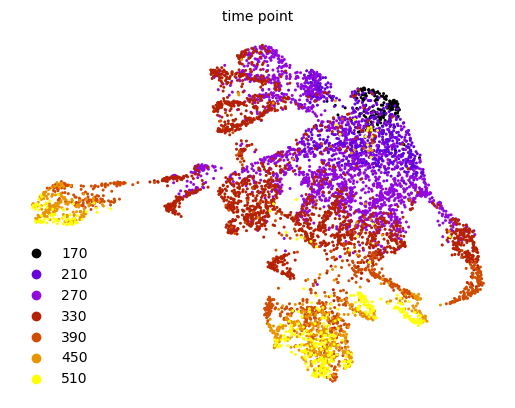

In [35]:
scv.pl.scatter(
    cdata,
    basis="umap",
    color=["time_point"],
    legend_loc="best",
)

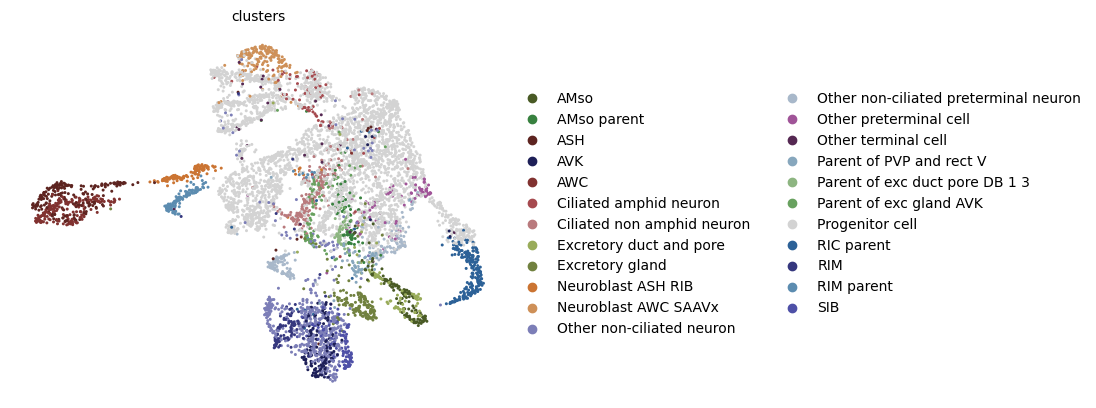

In [36]:
scv.pl.scatter(
    cdata,
    basis="umap",
    color=["clusters"],
    legend_loc="right",
)

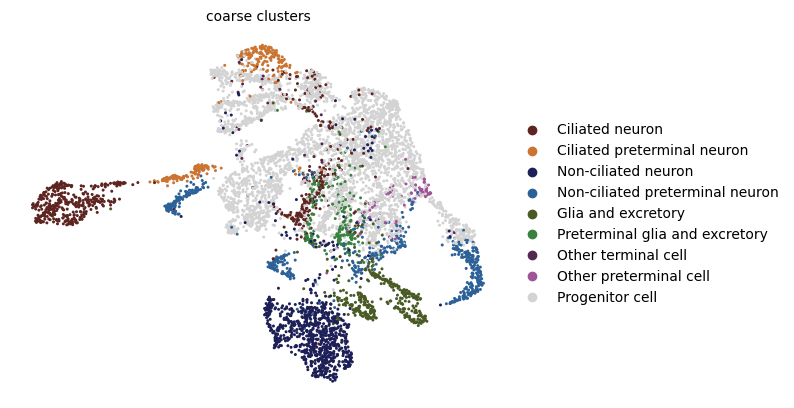

In [37]:
scv.pl.scatter(
    cdata,
    basis="umap",
    color=["coarse_clusters"],
    legend_loc="right",
)